In [1]:
from kafka import KafkaConsumer
from tensorflow import keras
from joblib import load
import pandas as pd
import numpy as np
np.float = float
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif as mi
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score
import river
from river import compose
from river import evaluate
from river import metrics
from river import preprocessing
from river import stream
from skmultiflow.evaluation import EvaluateHoldout
from skmultiflow.data import DataStream
from sklearn.metrics import f1_score
import warnings
from river.drift import ADWIN, PageHinkley
from sklearn.base import clone
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import copy
warnings.filterwarnings("ignore")
%matplotlib inline
# or
%matplotlib widget

2023-11-13 11:57:03.488233: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 11:57:06.481237: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-13 11:57:06.482873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 11:57:07.728612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="kafka:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [3]:
# Load your initial Keras model
static_model = load('please.joblib')

[11:57:13] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [4]:
dynamic_model = copy.deepcopy(static_model)

In [5]:
# Set the desired window size
window_size = 1000

In [6]:
def deserialize(data):
    
    # Decode byte string and split by comma
    decoded_data = data.decode('utf-8').strip().split(',')
    
    # Remove additional characters from the 'Target Attack' field
    target_attack = decoded_data[15].strip().strip('\\n"')
    
    # Convert to appropriate data types
    data_dict = {
        'timestamp': decoded_data[0].strip('"'),
        'FQDN_count': int(decoded_data[1]),
        'subdomain_length': int(decoded_data[2]),
        'upper': int(decoded_data[3]),
        'lower': int(decoded_data[4]),
        'numeric': int(decoded_data[5]),
        'entropy': float(decoded_data[6]),
        'special': int(decoded_data[7]),
        'labels': int(decoded_data[8]),
        'labels_max': int(decoded_data[9]),
        'labels_average': float(decoded_data[10]),
        'longest_word': decoded_data[11],
        'sld': decoded_data[12],
        'len': int(decoded_data[13]),
        'subdomain': int(decoded_data[14]),
        'Target Attack': int(target_attack)
    }
    
    df = pd.DataFrame([data_dict])

    return df

In [7]:
def impute_with_max(df):
    for column in df.columns:
        # Check if the column is numerical
        if pd.api.types.is_numeric_dtype(df[column]):
            max_value = df[column].max()
            df[column].fillna(max_value, inplace=True)
        else:
            # For non-numeric columns, consider using mode (most frequent value) or another method
            most_common = df[column].mode().iloc[0]
            df[column].fillna(most_common, inplace=True)

    return df

In [8]:
def preprocess(df):
    df = df.drop(columns='timestamp')
    
    df = impute_with_max(df)
    
    types = df.dtypes
    #Indexes of categorical columns
    categorical_indexes = (types == 'object')
    #Indexes of numerical columns
    numerical_indexes = ~categorical_indexes
    
    columns = df.columns
    numerical_columns = columns[numerical_indexes]
    categorical_columns = columns[categorical_indexes]
    
    # For outliers, we'll cap the values at the 1st and 99th percentiles for each numerical feature
    for feature in numerical_columns:
        # Calculate the 1st and 99th percentiles
        lower_bound, upper_bound = df[feature].quantile([0.01, 0.99]).values
        # Cap the outliers
        df[feature] = np.clip(df[feature], lower_bound, upper_bound)
        
    # Length of the second-level domain
    df['sld_length'] = df['sld'].apply(len)
    # Presence of numeric characters in the second-level domain
    df['sld_numeric'] = df['sld'].str.contains('\d').astype(int)
    
    # Length of the longest word
    df['longest_word_length'] = df['longest_word'].apply(len)
    # Presence of numeric characters in the longest word
    df['longest_word_numeric'] = df['longest_word'].str.contains('\d').astype(int)
    
    n_features = 2**4
    # Initialize the FeatureHasher
    hasher_longest_word = FeatureHasher(n_features=n_features, input_type='string')
    hasher_sld = FeatureHasher(n_features=n_features, input_type='string')
    words_longest_word = df['longest_word'].astype(str).map(lambda x: x.split())
    words_sld = df['sld'].astype(str).map(lambda x: x.split())
    hashed_features_longest_word = hasher_longest_word.transform(words_longest_word)
    hashed_features_sld = hasher_sld.transform(words_sld)
    hashed_longest_word_df = pd.DataFrame(hashed_features_longest_word.toarray(),columns=[f'lw_hash_{i}' for i in range(hashed_features_longest_word.shape[1])])
    hashed_sld_df = pd.DataFrame(hashed_features_sld.toarray(), columns=[f'sld_hash_{i}' for i in range(hashed_features_sld.shape[1])])
    
    df.reset_index(drop=True, inplace=True)
    hashed_sld_df.reset_index(drop=True, inplace=True)
    hashed_longest_word_df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, hashed_sld_df, hashed_longest_word_df], axis=1)
    
    df = df.drop(['longest_word', 'sld'], axis=1)
    features = ['FQDN_count', 'subdomain_length', 'lower', 'numeric', 'entropy',
       'special', 'labels', 'labels_max', 'labels_average', 'sld_length',
       'sld_numeric', 'longest_word_length', 'longest_word_numeric']
    
    y = df['Target Attack']
    X = df[features]
    
    
    return X, y
    
    

In [9]:
from skmultiflow.evaluation import EvaluateHoldout
from skmultiflow.data import DataStream

In [10]:
# Initialize the EvaluateHoldout evaluator
hold_evaluator_static = EvaluateHoldout(max_samples=1000,
                                        n_wait=100,
                                        test_size=500,
                                        show_plot=False,
                                        metrics=['accuracy', 'f1', 'precision', 'recall'])

hold_evaluator_dynamic = EvaluateHoldout(max_samples=20000,
                                         n_wait=500,
                                         test_size=1000,
                                         show_plot=False,
                                         metrics=['accuracy', 'f1', 'precision', 'recall'])

In [11]:
# Initialize variables for window processing
window_data = []
window_size = 1000
performance_static = []
performance_dynamic = []

In [12]:
# Initialize drift detectors
adwin = ADWIN()
ph = PageHinkley(min_instances=500, alpha=1.01)

In [13]:
def should_retrain(stream, y_true, y_pred, adwin, ph):
    """
    Determine if the model should be retrained based on error rates and drift detection.
    
    :param stream: The stream of incoming data points.
    :param y_true: The true labels for the stream data.
    :param y_pred: The predicted labels for the stream data.
    :param adwin: The ADWIN drift detection method instance.
    :param ph: The Page-Hinkley drift detection method instance.
    :return: Boolean indicating whether retraining is necessary.
    """
    errors = [1 if yt != yp else 0 for yt, yp in zip(y_true, y_pred)]  # Binary classification error
    drift_detected = False
    
    for error in errors:
        # Update the ADWIN and Page-Hinkley models and check for drift
        adwin.update(error)
        _ = ph.update(error)
        
        if adwin.drift_detected or ph.drift_detected:
            drift_detected = True
            # As best practice, reset the detectors after drift is detected
            break  # Exit loop if drift is detected

    return drift_detected

In [14]:
for message in consumer:
    try:
        # Deserialize your message here
        df = deserialize(message.value) 

        # Add to window data
        window_data.append(df)

        # Check if the window is filled
        if len(window_data) >= window_size:
            # Convert window data to a suitable format for model input
            window_df = pd.concat(window_data, ignore_index=True)

            X , y = preprocess(window_df)
            y = y.astype(int)

           # Evaluate the static model
            y_pred_static = static_model.predict(X)
            accuracy_static = accuracy_score(y, y_pred_static)
            precision_static = precision_score(y, y_pred_static)
            recall_static = recall_score(y, y_pred_static)
            f1_static = f1_score(y, y_pred_static)

            # Store and print static model performance
            metrics_static = {'accuracy': accuracy_static, 'precision': precision_static, 'recall': recall_static, 'f1_score': f1_static}
            performance_static.append(metrics_static)
            print("Static Model - Window:", len(performance_static))
            print("Accuracy:", accuracy_static, "Precision:", precision_static, "Recall:", recall_static, "F1 Score:", f1_static)

           # Evaluate the dynamic model
            y_pred_dynamic = dynamic_model.predict(X)
            accuracy_dynamic = accuracy_score(y, y_pred_dynamic)
            precision_dynamic = precision_score(y, y_pred_dynamic)
            recall_dynamic = recall_score(y, y_pred_dynamic)
            f1_dynamic = f1_score(y, y_pred_dynamic)

            # Store and print dynamic model performance
            metrics_dynamic = {'accuracy': accuracy_dynamic, 'precision': precision_dynamic, 'recall': recall_dynamic, 'f1_score': f1_dynamic}
            performance_dynamic.append(metrics_dynamic)
            print("Dynamic Model - Window:", len(performance_dynamic))
            print("Accuracy:", accuracy_dynamic, "Precision:", precision_dynamic, "Recall:", recall_dynamic, "F1 Score:", f1_dynamic)
            
            

            # Decide if retraining is necessary for the dynamic model
            if should_retrain(stream, y, y_pred_dynamic, adwin, ph):  # Implement this function based on your criteria
                print("Retraining dynamic model...")
                dynamic_model.fit(X, y)
                print("Dynamic model retrained.")

            # Reset for the next window
            window_data = []
            window_labels = []

    except ValueError as e:
        continue

Static Model - Window: 1
Accuracy: 0.81 Precision: 0.7376586741889986 Recall: 0.9924098671726755 F1 Score: 0.8462783171521036
Dynamic Model - Window: 1
Accuracy: 0.81 Precision: 0.7376586741889986 Recall: 0.9924098671726755 F1 Score: 0.8462783171521036
Retraining dynamic model...
Dynamic model retrained.
Static Model - Window: 2
Accuracy: 0.809 Precision: 0.7440890125173852 Recall: 0.9870848708487084 F1 Score: 0.8485329103885805
Dynamic Model - Window: 2
Accuracy: 0.812 Precision: 0.7451523545706371 Recall: 0.992619926199262 F1 Score: 0.8512658227848102
Static Model - Window: 3
Accuracy: 0.788 Precision: 0.7245590230664858 Recall: 0.9834254143646409 F1 Score: 0.8343750000000001
Dynamic Model - Window: 3
Accuracy: 0.796 Precision: 0.728744939271255 Recall: 0.994475138121547 F1 Score: 0.8411214953271029
Static Model - Window: 4
Accuracy: 0.814 Precision: 0.7574931880108992 Recall: 0.9858156028368794 F1 Score: 0.8567026194144837
Dynamic Model - Window: 4
Accuracy: 0.814 Precision: 0.75890

KeyboardInterrupt: 

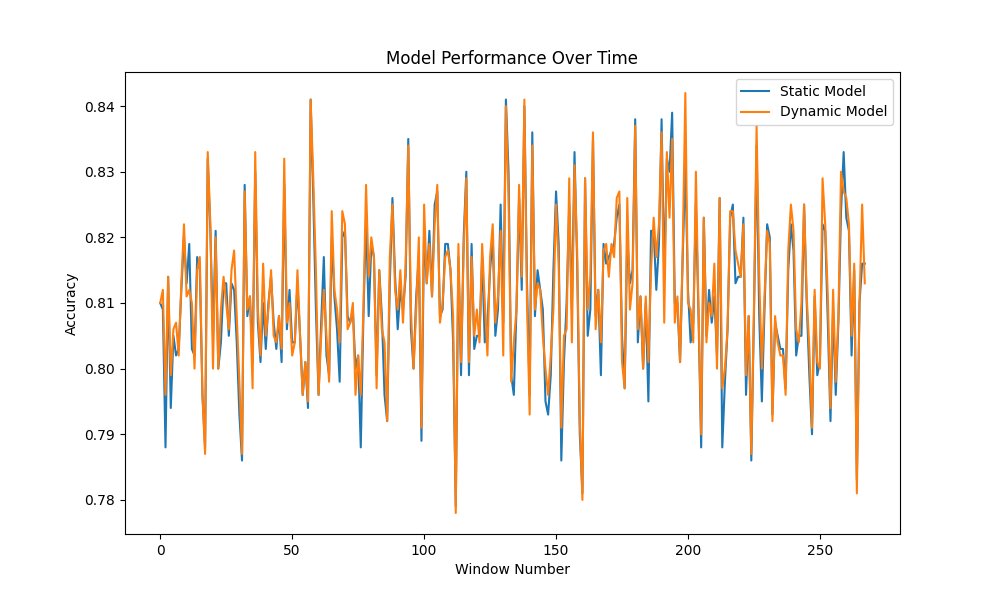

In [15]:
# Extract accuracy values for plotting
accuracy_static = [metrics['accuracy'] for metrics in performance_static]
accuracy_dynamic = [metrics['accuracy'] for metrics in performance_dynamic]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(accuracy_static, label='Static Model')
plt.plot(accuracy_dynamic, label='Dynamic Model')
plt.xlabel('Window Number')
plt.ylabel('Accuracy')
plt.title('Model Performance Over Time')
plt.legend()
plt.show()